# Team Project

- Type: a competition-based project with a leader board (training datasets is released on lecture's kaggle competition page)

- Objective: maximizing the test accuracy under the condition:
    - PART 1: under 2,000,000 (2M) parameters

## CAUTION

- You can change **only** the **[Define Model](#scrollTo=9ViRr0JT84C7)**, **[Train Model](#scrollTo=NSFY5dyOm-qA)** and **[Hyperparameters](#scrollTo=Pv-hIWaJomEf)** sections. (You can also change test transform part in eval cell)
- You can use any kind of deep neural networks and apply any optimization techniques to improve the performance.
- You can't use imagenet pretrained model and extra datasets. (***USE only given dataset***)

## Mount Google Drive and Download training&test datasets

First, Download datasets from [this lecture's kaggle competition page](https://www.kaggle.com/c/khu-machine-learning-competition/data) and upload your Google Drive.

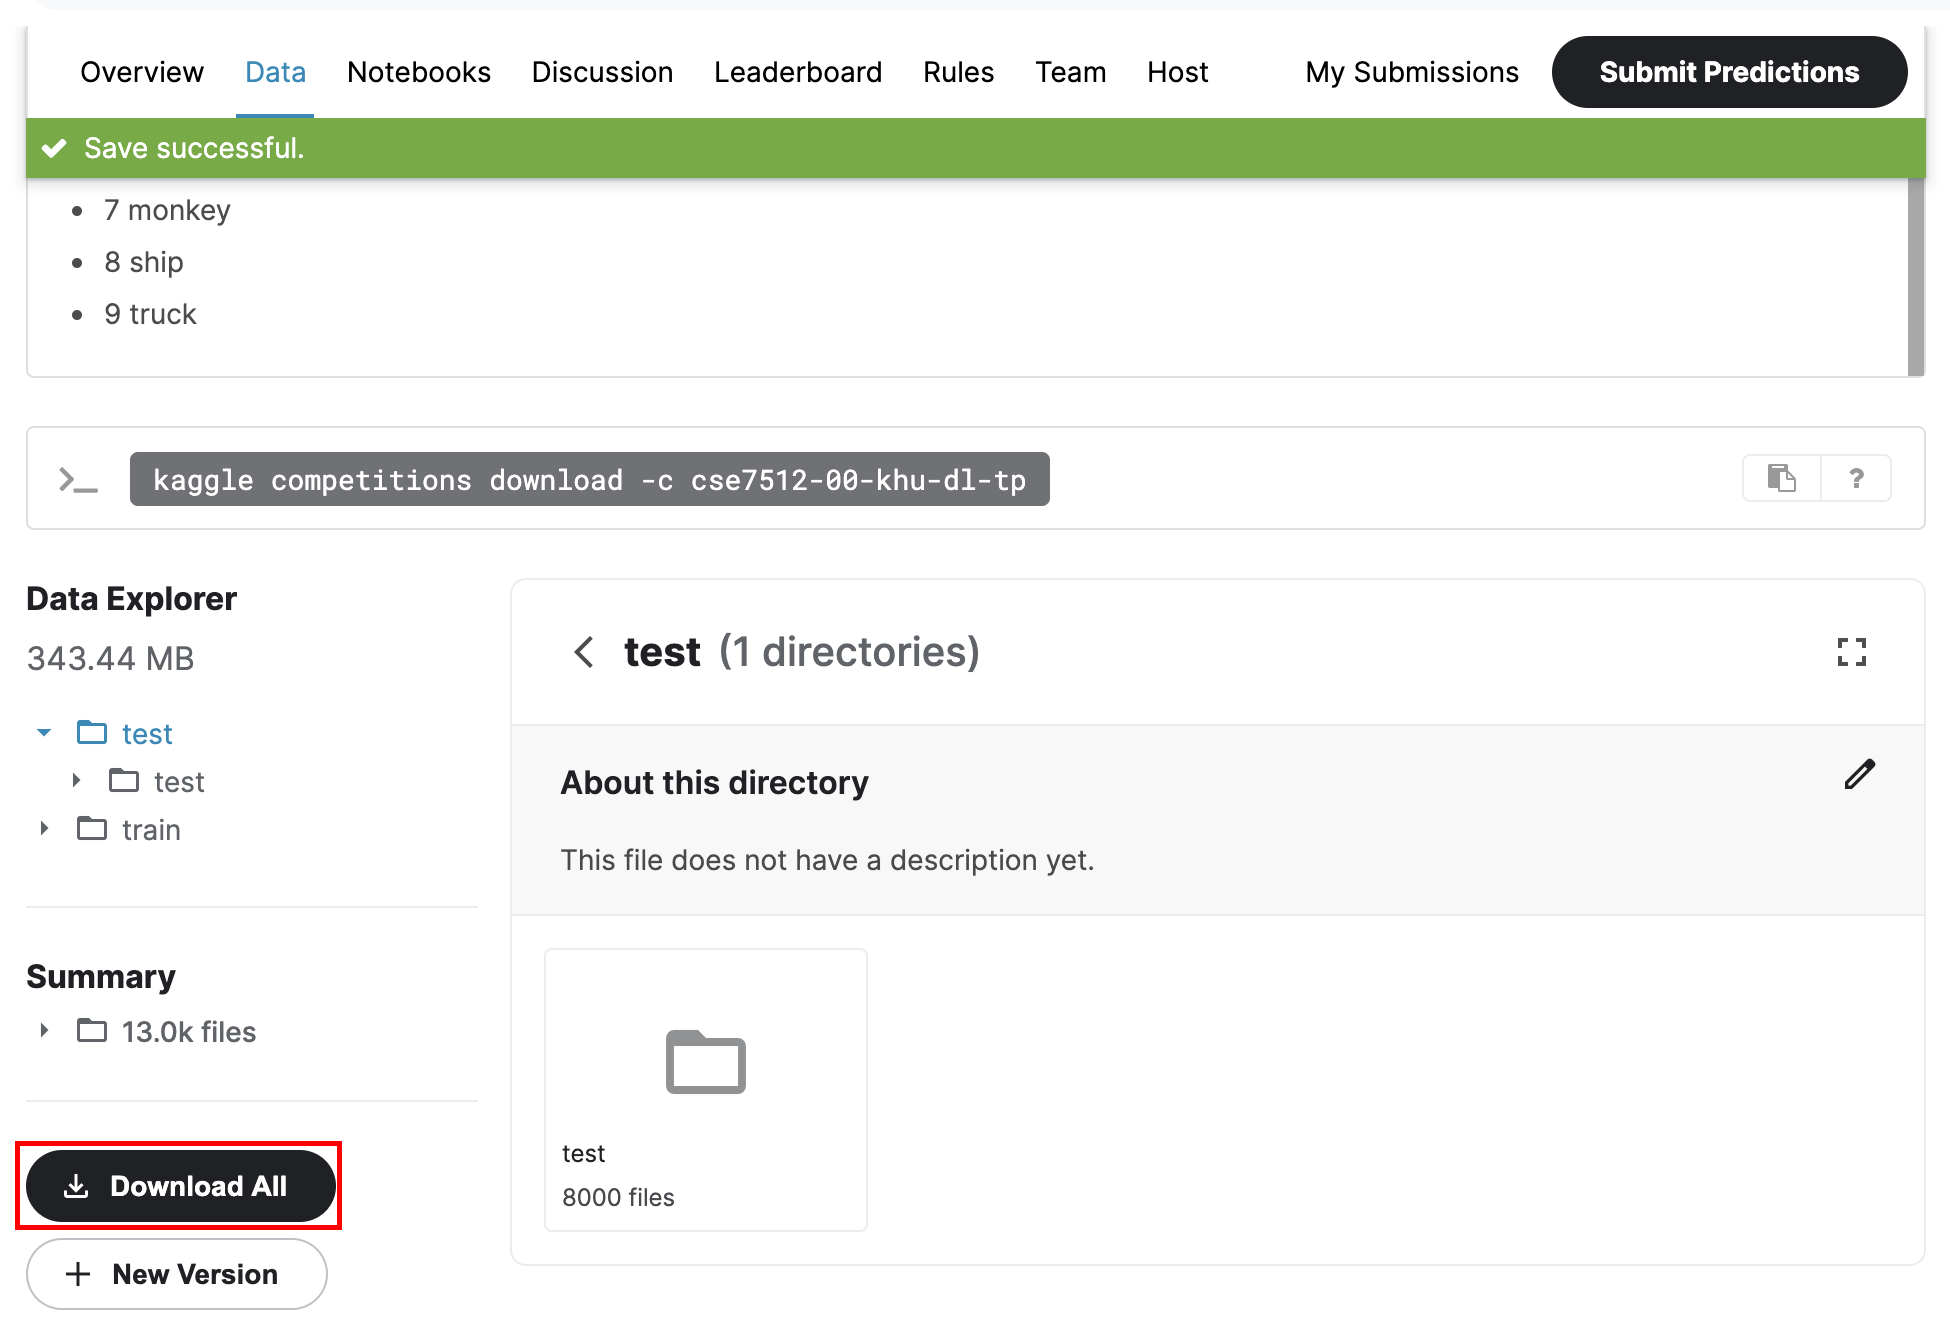

**You shuold upload dataset zip file to `My Drive/CSE331_ML_Project/`.**

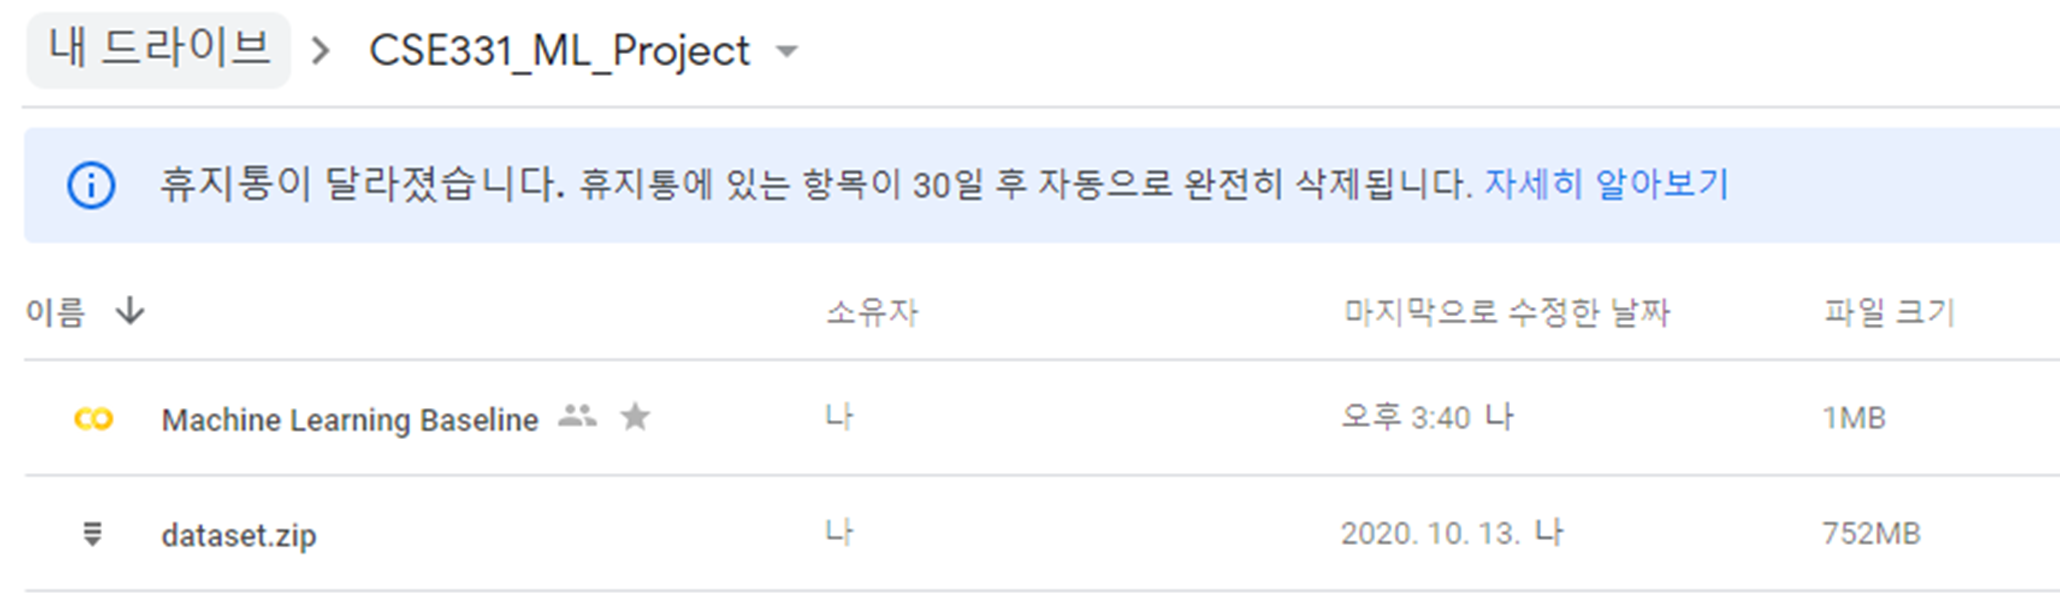

Then, mount your google drive on this session.

In [ ]:
from google.colab import drive

# Accessing My Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


### mount google drive example

1. Execute the mount cell and click that https URL below picture  
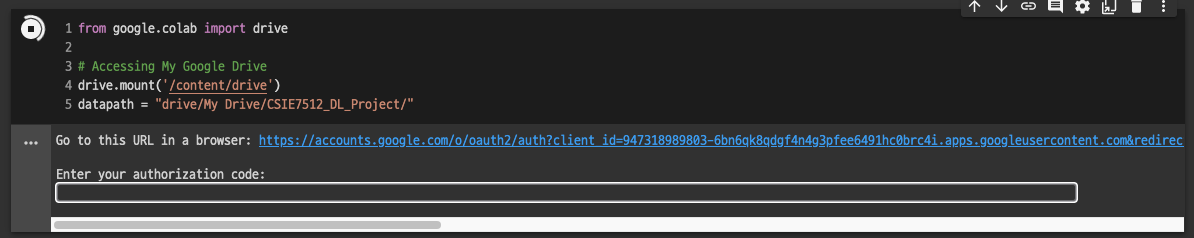

2. Click your account  
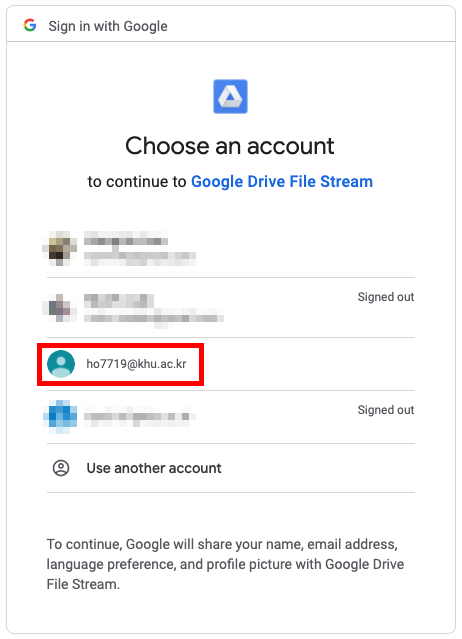

3. Click allow button  
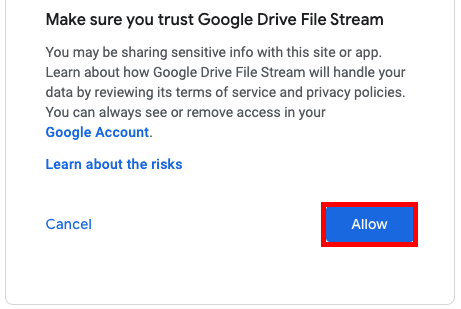

4. Copy the authorization code  
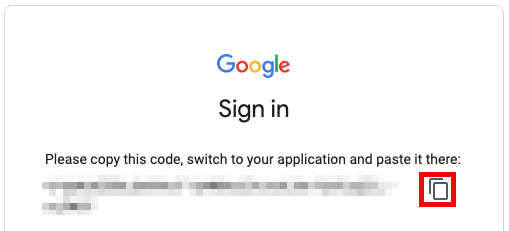


5. Enter the authorization code   
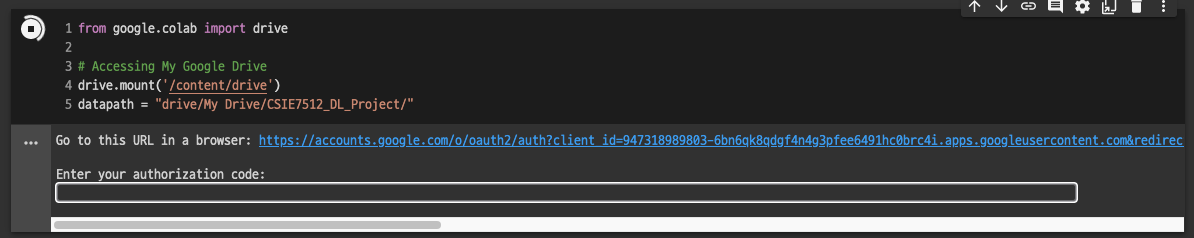

6. Done!  
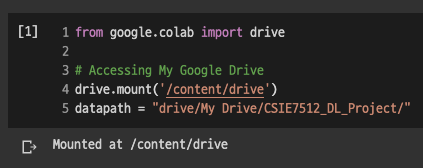

## Unzip dataset on runtime session

In [ ]:
!unzip '/content/drive/My Drive/CSE331_ML_Project/dataset.zip'

## Define Model

In [ ]:
import torch
import torch.nn as nn


class LeNet_STL10(nn.Module):
    def __init__(self):
        super(LeNet_STL10, self).__init__()
        self.num_classes = 10

        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1)
        self.pool1 = nn.MaxPool2d((2, 2), stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.pool2 = nn.MaxPool2d((2, 2), stride=2)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, self.num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)

        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x


def Model():
    r"""Return your custom model
    """
    return LeNet_STL10()

## utils

In [ ]:
class AverageMeter(object):
    r"""Computes and stores the average and current value
    """
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, *meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def print(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def accuracy(output, target, topk=(1,)):
    r"""Computes the accuracy over the $k$ top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # _, pred = output.topk(maxk, 1, True, True)
        # pred = pred.t()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))

        # faster topk (ref: https://github.com/pytorch/pytorch/issues/22812)
        _, idx = output.sort(descending=True)
        pred = idx[:,:maxk]
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

## Hyperparameters

In [ ]:
SAVEPATH = '/content/drive/My Drive/CSE331_ML_Project/'
WEIGHTDECAY = 5e-4
MOMENTUM = 0.9
BATCHSIZE = 256
LR = 0.1
EPOCHS = 200
PRINTFREQ = 10

## Train Model

In [ ]:
import time

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


def main():
    model = Model()

    ##### optimizer / learning rate scheduler / criterion #####
    optimizer = torch.optim.SGD(model.parameters(), lr=LR,
                                momentum=MOMENTUM, weight_decay=WEIGHTDECAY,
                                nesterov=True)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [100, 150],
                                                     gamma=0.1)
    criterion = torch.nn.CrossEntropyLoss()
    ###########################################################

    model = model.cuda()
    criterion = criterion.cuda()

    # Check number of parameters your model
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {pytorch_total_params}")
    if int(pytorch_total_params) > 2000000:
        print('Your model has the number of parameters more than 2 millions..')
        return

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])

    valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    train_dataset = torchvision.datasets.ImageFolder(
        './train', transform=train_transform)
    train_loader = DataLoader(train_dataset,
                              batch_size=BATCHSIZE, shuffle=True,
                              num_workers=4, pin_memory=True)
    
    val_dataset = torchvision.datasets.ImageFolder('./valid', transform=valid_transform)

    last_top1_acc = 0
    for epoch in range(EPOCHS):
        print("\n----- epoch: {}, lr: {} -----".format(
            epoch, optimizer.param_groups[0]["lr"]))

        # train for one epoch
        start_time = time.time()
        last_top1_acc = train(train_loader, epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to train this epoch\n'.format(
            elapsed_time))

        # learning rate scheduling
        scheduler.step()

        # Save model each epoch
        torch.save(model.state_dict(), SAVEPATH+'model_weight.pth')

    print(f"Last Top-1 Accuracy: {last_top1_acc}")
    print(f"Number of parameters: {pytorch_total_params}")



def train(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        input = input.cuda()
        target = target.cuda()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINTFREQ == 0:
            progress.print(i)

    print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))
    return top1.avg


if __name__ == "__main__":
    main()

## Make an evalutation csv file

This code makes an evaluation csv file for kaggle submission.


In [ ]:
import torch
import pandas as pd
import argparse
import time
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

class TestImageFolder(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        # return image path
        return super(TestImageFolder, self).__getitem__(index), self.imgs[index][0].split('/')[-1]


def eval():
    ########## You can change this part only in this cell ##########
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])
    ################################################################

    test_dataset = TestImageFolder('./test', transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=BATCHSIZE, num_workers=4, shuffle=False)

    model = Model()
    model = model.cuda()
    model.load_state_dict(torch.load(SAVEPATH+'model_weight.pth'))
    model.eval()

    print('Make an evaluation csv file for kaggle submission...')
    Category = []
    Id = []
    for data in test_loader:
        (input, _), name = data
        
        input = input.cuda()
        output = model(input)
        output = torch.argmax(output, dim=1)
        Id = Id + list(name)
        Category = Category + output.tolist()

    #Id = list(range(0, 90000))
    samples = {
       'Id': Id,
       'Target': Category 
    }
    df = pd.DataFrame(samples, columns=['Id', 'Target'])

    df.to_csv(SAVEPATH+'submission.csv', index=False)
    print('Done!!')


if __name__ == "__main__":
    eval()

Make an evaluation csv file for kaggle submission...
Done!!


## Upload your submission on kaggle

1. Download the submission csv file  
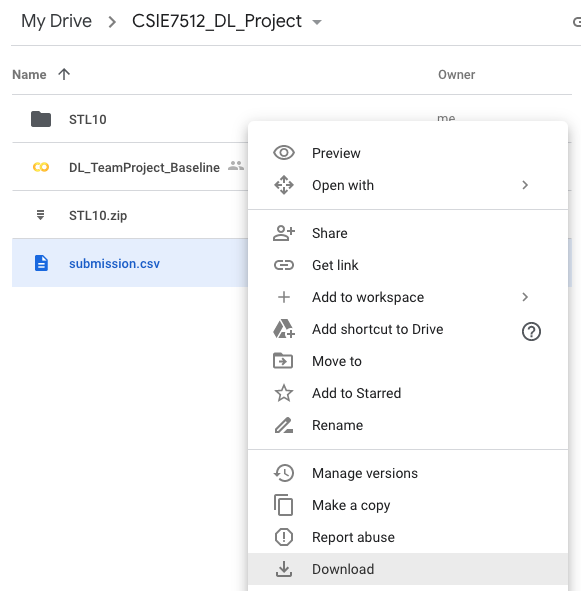

2. Go to [our kaggle submission link](https://www.kaggle.com/c/khu-machine-learning-competition) and click `Submit Predicitions` button  
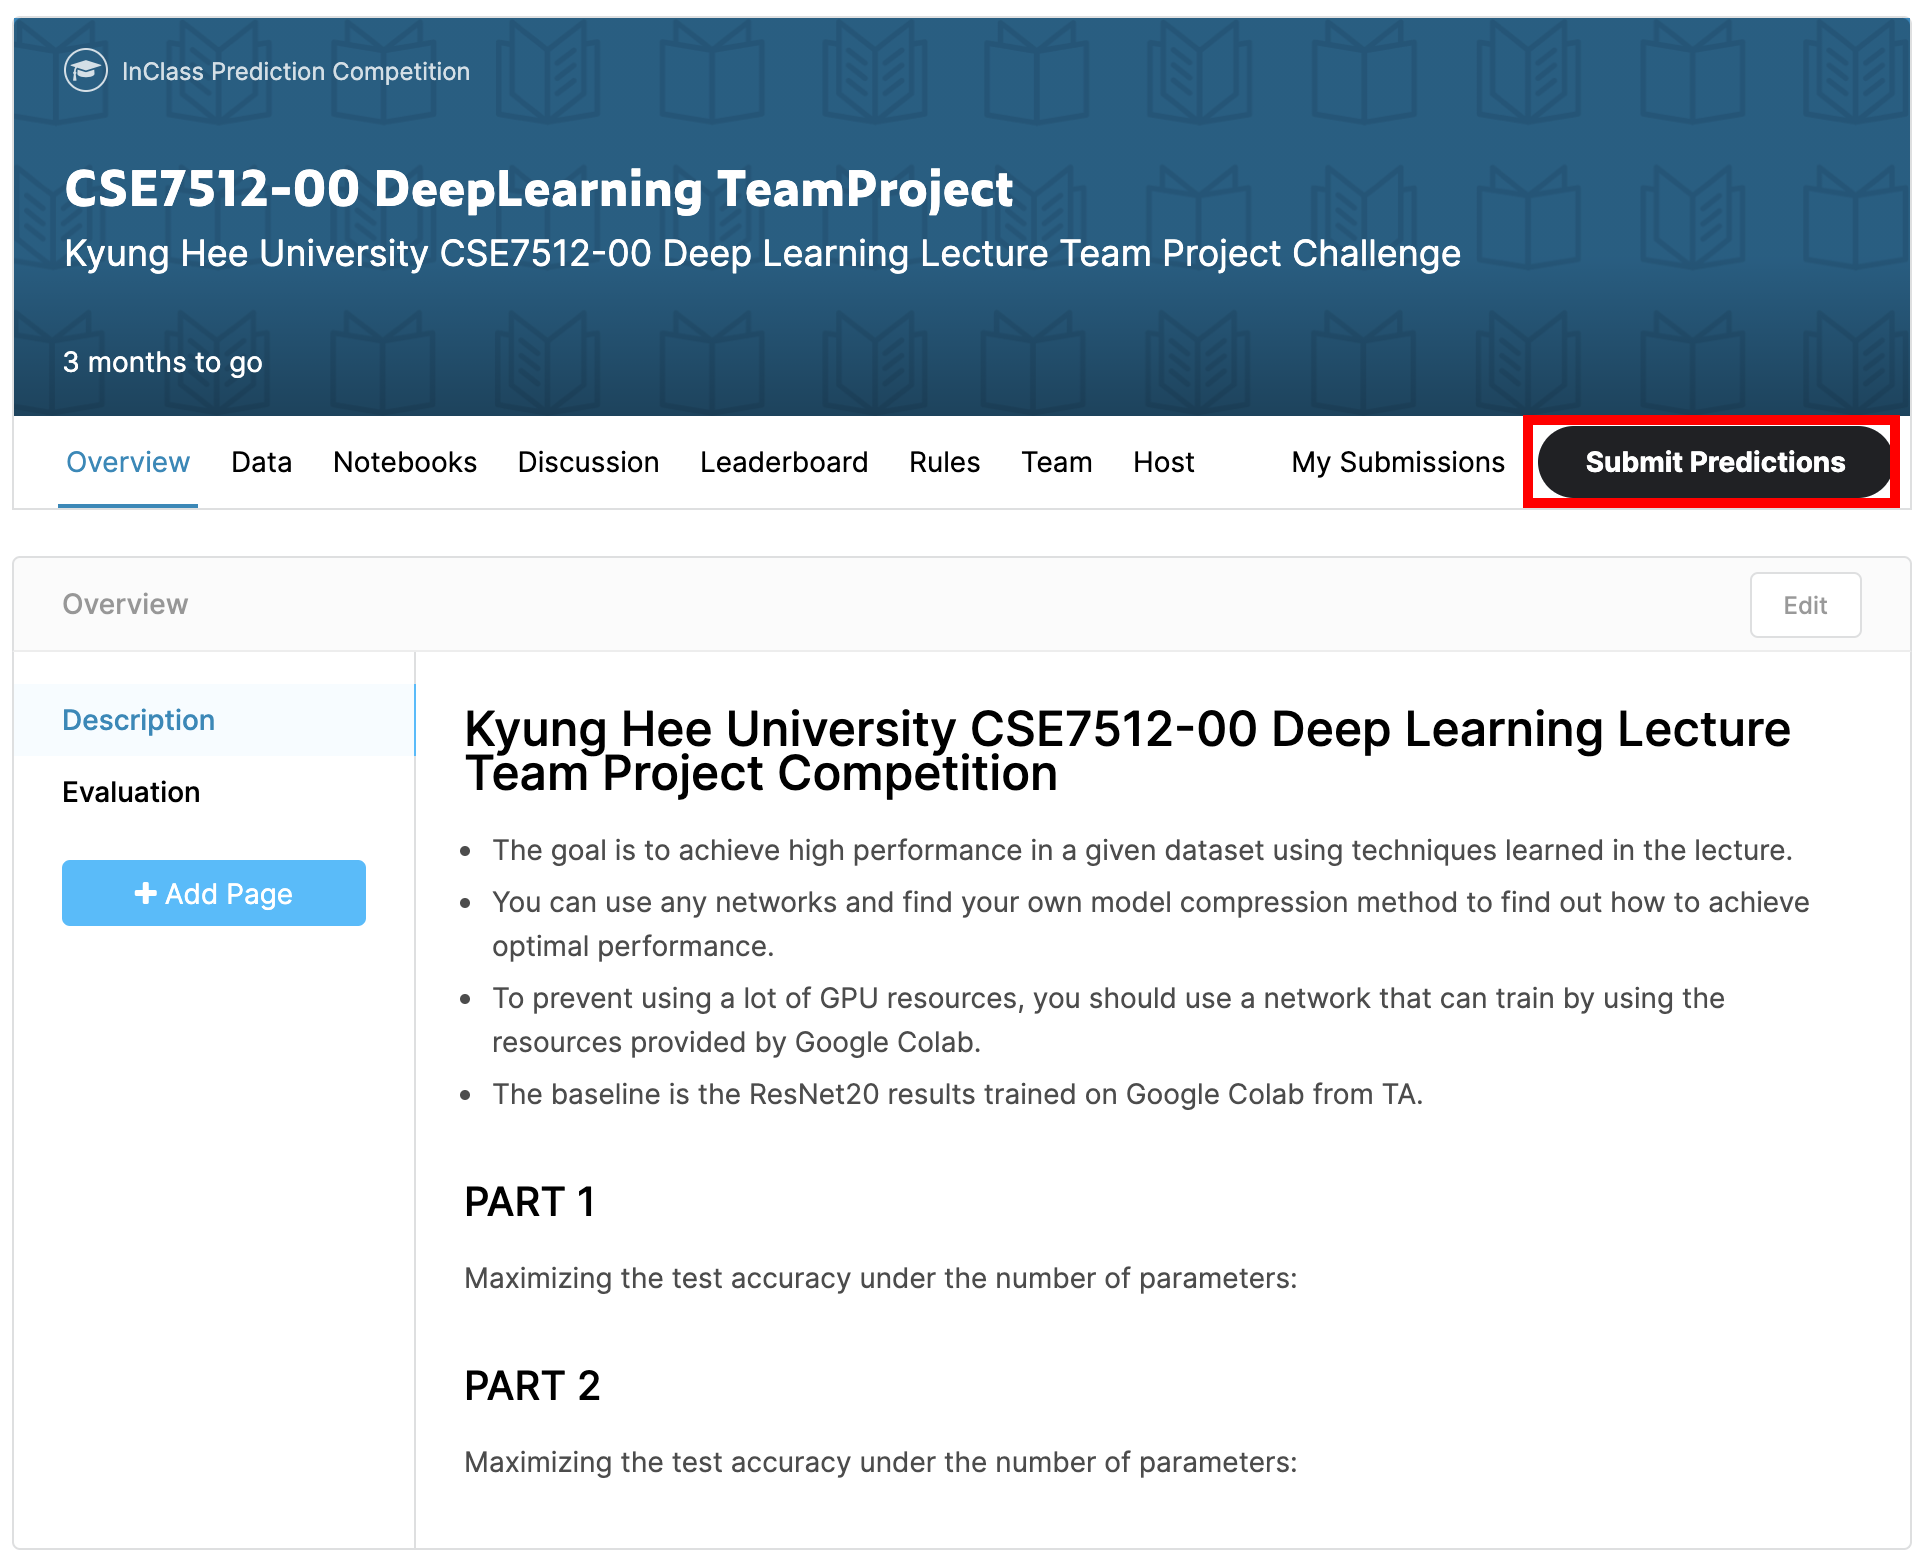

3. Upload Submission `csv` file and click `make submission` button  
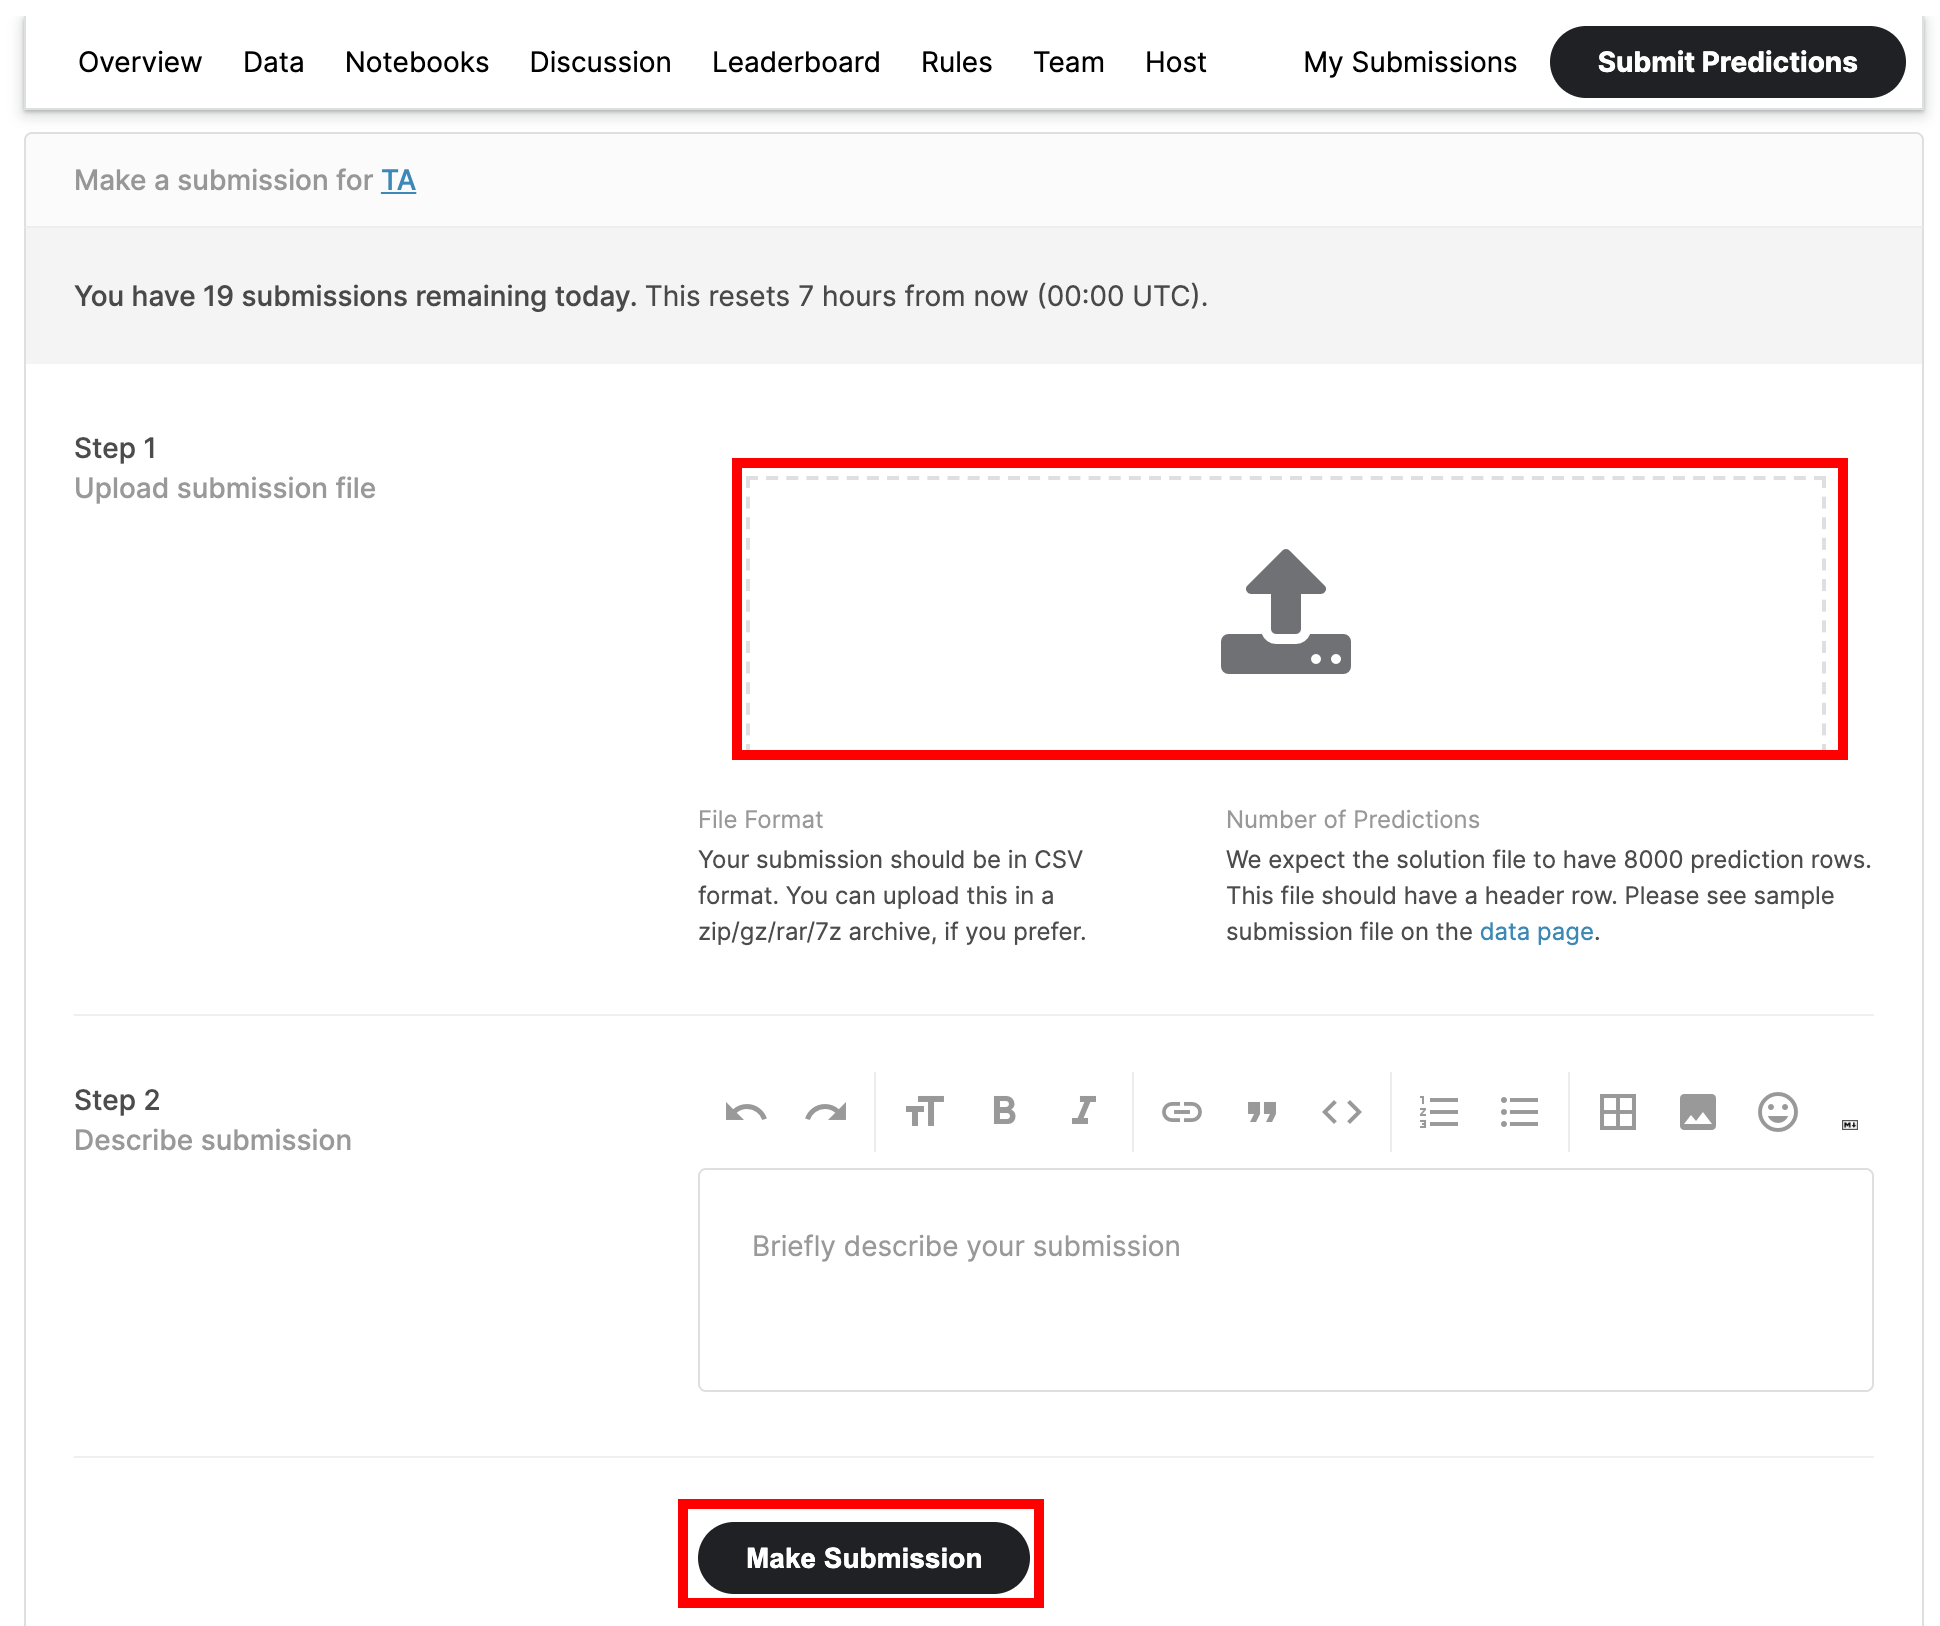

